### 🎖️ Objetivo
Realizar un análisis churn para la compañía TelecomX Latam, identificando las principales causas que explican la pérdida de clientes y proponiendo estrategias para mitigar esta situación y mejorar la retención.

In [22]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


In [2]:
url = "https://raw.githubusercontent.com/sthemonica/alura-voz/refs/heads/main/Dados/Telco-Customer-Churn.json"

- customerID: número de identificación único de cada cliente
- Churn: si el cliente dejó o no la empresa
- gender: género (masculino y femenino)
- SeniorCitizen: información sobre si un cliente tiene o no una edad    igual o mayor a 65 años
- Partner: si el cliente tiene o no una pareja
- Dependents: si el cliente tiene o no dependientes
- tenure: meses de contrato del cliente
- PhoneService: suscripción al servicio telefónico
- MultipleLines: suscripción a más de una línea telefónica
- InternetService: suscripción a un proveedor de internet
- OnlineSecurity: suscripción adicional de seguridad en línea
- OnlineBackup: suscripción adicional de respaldo en línea
- DeviceProtection: suscripción adicional de protección del dispositivo
- TechSupport: suscripción adicional de soporte técnico, menor tiempo de espera
- StreamingTV: suscripción de televisión por cable
- StreamingMovies: suscripción de streaming de películas
- Contract: tipo de contrato
- PaperlessBilling: si el cliente prefiere recibir la factura en línea
- PaymentMethod: forma de pago
- Charges.Monthly: total de todos los servicios del cliente por mes
- Charges.Total: total gastado por el cliente

In [3]:
datos = requests.get(url)
datos = datos.json()
data = pd.DataFrame(datos)
data.head(3)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [4]:
df = pd.json_normalize(datos)
df.head(3)

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [5]:
df.shape

(7267, 21)

In [6]:
df.info()
# No tiene valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [7]:
# Verificamos si tiene cadenas vacías
(df.astype(str).apply(lambda x: x.str.strip() == '')).sum()


,0
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [8]:
# Churn tiene 224 datos con cadenas vacía, vamos a eliminarlas
df = df[df['Churn'] != '']
len(df['Churn'])

7043

In [9]:
# account.Charges.Total	tiene 11 es muy inferior al 1% de los datos, podemos reemplazarlos por 0 pero primero hay que cambiar el tipo a float
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df['account.Charges.Total'].dtype




dtype('float64')

In [10]:
(df.astype(str).apply(lambda x: x.str.strip() == '')).sum()

,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [11]:
# Duplicados
df.duplicated().sum()

np.int64(0)

In [12]:
# feature engineering (ingeniería de características)- Agregamos la columna account.Charges.Diary
df['account.Charges.Daily'] =df['account.Charges.Monthly']/30

In [13]:
df['account.Charges.Daily']

,account.Charges.Daily
0,2.186667
1,1.996667
2,2.463333
3,3.266667
4,2.796667
...,...
7262,1.838333
7263,2.836667
7264,1.676667
7265,2.261667


In [16]:
df['customer.TenureGroup'] = pd.cut(df['customer.tenure'], bins=[0, 12, 24, 60, 100],
                                    labels=['Nuevo', 'Estable', 'Leal', 'Veterano'])

In [17]:
df['customer.TenureGroup']

,customer.TenureGroup
0,Nuevo
1,Nuevo
2,Nuevo
3,Estable
4,Nuevo
...,...
7262,Estable
7263,Estable
7264,Nuevo
7265,Veterano


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   object  
 1   Churn                      7043 non-null   object  
 2   customer.gender            7043 non-null   object  
 3   customer.SeniorCitizen     7043 non-null   int64   
 4   customer.Partner           7043 non-null   object  
 5   customer.Dependents        7043 non-null   object  
 6   customer.tenure            7043 non-null   int64   
 7   phone.PhoneService         7043 non-null   object  
 8   phone.MultipleLines        7043 non-null   object  
 9   internet.InternetService   7043 non-null   object  
 10  internet.OnlineSecurity    7043 non-null   object  
 11  internet.OnlineBackup      7043 non-null   object  
 12  internet.DeviceProtection  7043 non-null   object  
 13  internet.TechSupport       7043 non-nu

In [19]:
df.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,2.158723
std,0.368612,24.559481,30.090047,2266.771362,1.003002
min,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,9.000000,35.500000,401.450000,1.183333
50%,0.000000,29.000000,70.350000,1397.475000,2.345000
75%,0.000000,55.000000,89.850000,3794.737500,2.995000
max,1.000000,72.000000,118.750000,8684.800000,3.958333


In [20]:
# Codificación de variables categóricas
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'customerID']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [21]:
df_encoded.head()

,customerID,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily,customer.TenureGroup,Churn_Yes,customer.gender_Male,customer.Partner_Yes,...,internet.StreamingTV_No internet service,internet.StreamingTV_Yes,internet.StreamingMovies_No internet service,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0002-ORFBO,0,9,65.6,593.30,2.186667,Nuevo,False,False,True,...,False,True,False,False,True,False,True,False,False,True
1,0003-MKNFE,0,9,59.9,542.40,1.996667,Nuevo,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,0004-TLHLJ,0,4,73.9,280.85,2.463333,Nuevo,True,True,False,...,False,False,False,False,False,False,True,False,True,False
3,0011-IGKFF,1,13,98.0,1237.85,3.266667,Estable,True,True,True,...,False,True,False,True,False,False,True,False,True,False
4,0013-EXCHZ,1,3,83.9,267.40,2.796667,Nuevo,True,False,True,...,False,True,False,False,False,False,True,False,False,True


In [23]:
# Escalado de características numéricas
scaler = StandardScaler()
numeric_cols = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'account.Charges.Daily']
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

In [24]:
df_encoded[numeric_cols]

,customer.tenure,account.Charges.Monthly,account.Charges.Total,account.Charges.Daily
0,-0.951682,0.027862,-0.745607,0.027862
1,-0.951682,-0.161583,-0.768063,-0.161583
2,-1.155283,0.303720,-0.883456,0.303720
3,-0.788800,1.104706,-0.461240,1.104706
4,-1.196004,0.636080,-0.889390,0.636080
...,...,...,...,...
7262,-0.788800,-0.319454,-0.679605,-0.319454
7263,-0.422317,0.675963,-0.180711,0.675963
7264,-1.236724,-0.480648,-0.966443,-0.480648
7265,1.410099,0.102643,1.034298,0.102643


### Análisis Exploratorio de Datos

/tmp/ipython-input-1663582775.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


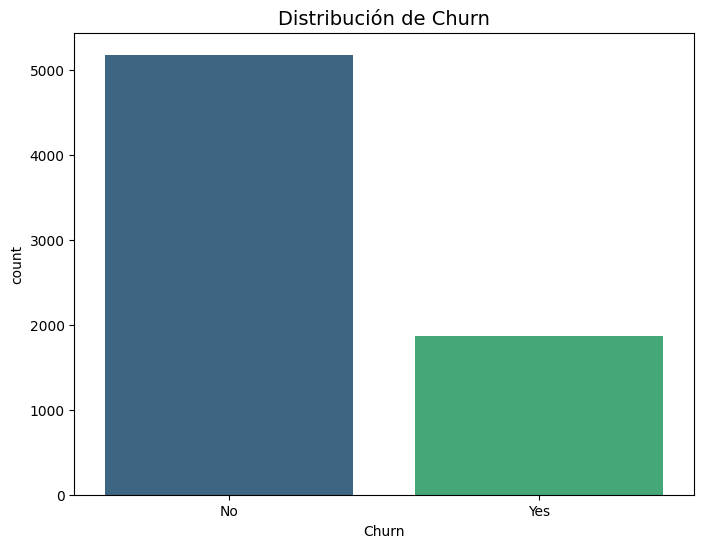

In [25]:
# 2.1. Distribución de churn
plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribución de Churn', fontsize=14)
plt.show()

In [29]:
print(f'Porcentaje de Churn: {round(df["Churn"].value_counts(normalize=True)[1]*100,2)}%')

Porcentaje de Churn: 26.54%


/tmp/ipython-input-2312992929.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Porcentaje de Churn: {round(df["Churn"].value_counts(normalize=True)[1]*100,2)}%')


In [30]:
print(f'Porcentaje de No Churn: {round(df["Churn"].value_counts(normalize=True)[0]*100,2)}%')

Porcentaje de No Churn: 73.46%


/tmp/ipython-input-3257919570.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Porcentaje de No Churn: {round(df["Churn"].value_counts(normalize=True)[0]*100,2)}%')


/tmp/ipython-input-2703255914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_matrix['Churn'] = corr_matrix['Churn'].map({'No':0, 'Yes':1})


Text(0.5, 1.0, 'Matriz de Correlación')

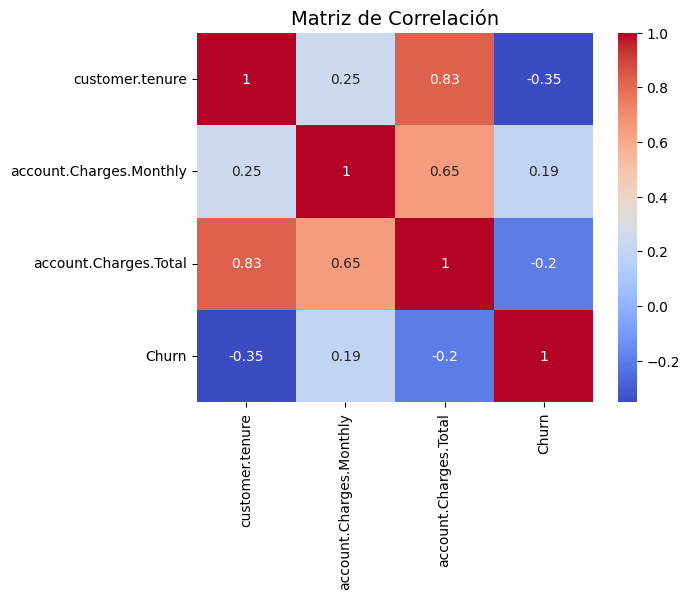

In [41]:
# Correlación con variables numéricas
corr_matrix = df[['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Churn']]
corr_matrix['Churn'] = corr_matrix['Churn'].map({'No':0, 'Yes':1})
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación', fontsize=14)

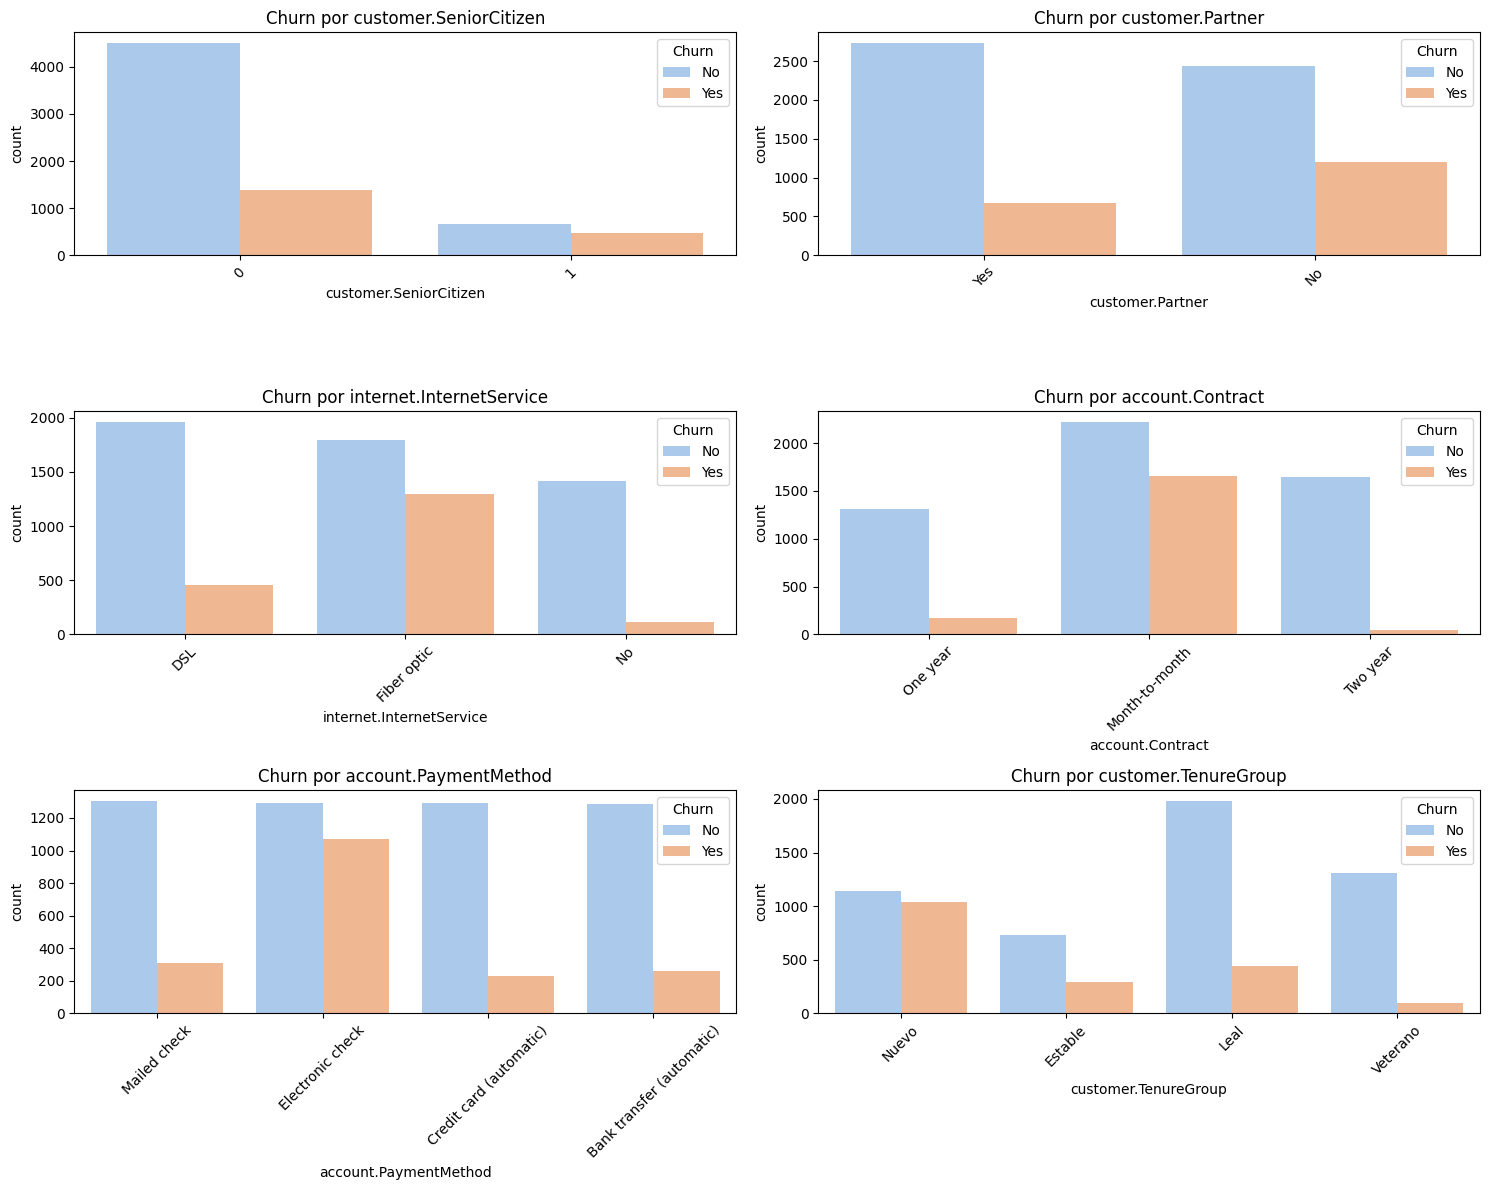

In [42]:
# Análisis de características categóricas
fig, axes = plt.subplots(3, 2, figsize=(15,12))
features_cat = ['customer.SeniorCitizen', 'customer.Partner', 'internet.InternetService',
                'account.Contract', 'account.PaymentMethod', 'customer.TenureGroup']

for i, feature in enumerate(features_cat):
    ax = axes[i//2, i%2]
    sns.countplot(x=feature, hue='Churn', data=df, ax=ax, palette='pastel')
    ax.set_title(f'Churn por {feature}')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

In [34]:
# Interacción entre servicios
df['internet.ServiceCount'] = df[['internet.OnlineSecurity', 'internet.OnlineBackup',
                                  'internet.DeviceProtection', 'internet.TechSupport']].apply(
    lambda x: x.isin(['Yes']).sum(), axis=1)

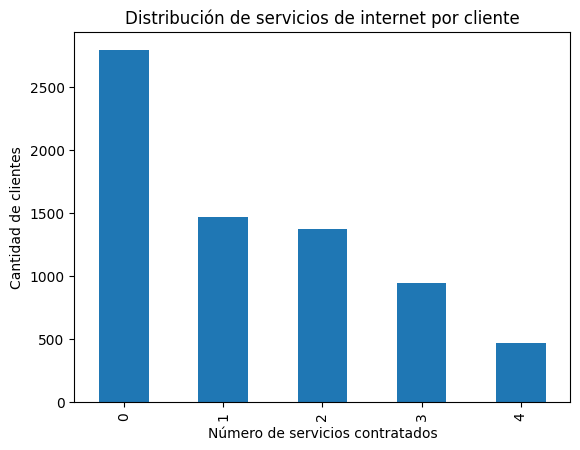

In [36]:
import matplotlib.pyplot as plt

df['internet.ServiceCount'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Número de servicios contratados')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de servicios de internet por cliente')
plt.show()


In [37]:
# Comportamiento de pago
df['account.PaymentIssues'] = df['account.PaymentMethod'].apply(
    lambda x: 1 if 'electronic' in x.lower() else 0)

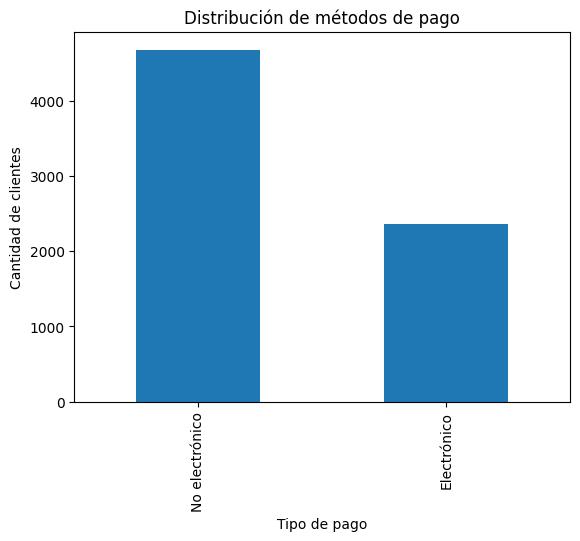

In [38]:
import matplotlib.pyplot as plt

df['account.PaymentIssues'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No electrónico', 'Electrónico'])
plt.xlabel('Tipo de pago')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de métodos de pago')
plt.show()


In [39]:
# Sensibilidad a precios
conditions = [
    (df['account.Charges.Monthly'] > df['account.Charges.Monthly'].quantile(0.75)),
    (df['account.Charges.Monthly'] < df['account.Charges.Monthly'].quantile(0.25))
]
choices = ['Alta', 'Baja']
df['account.PriceSensitivity'] = np.select(conditions, choices, default='Media')

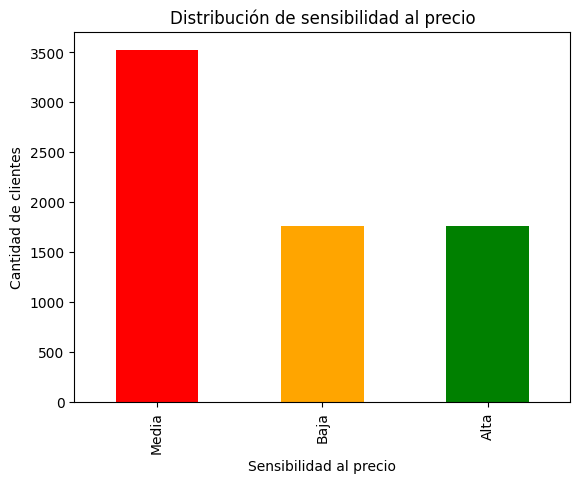

In [40]:
import matplotlib.pyplot as plt

df['account.PriceSensitivity'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.xlabel('Sensibilidad al precio')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de sensibilidad al precio')
plt.show()
